In [1]:
#importing Libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#reading data file
df= pd.read_excel(r"C:\Users\SATYAM\Downloads\pharma_forecasting_dummy_custom_500.xlsx")

In [3]:
df.head(5)

,Year,Country,Product Name,Dosage Form,Manufacturer,Price (USD),Units,Market / Channel,Sales (USD)
0,2025,India,DrugD,Syrup,Novartis,474.74,156,Retail,74059.44
1,2025,India,DrugB,Capsule,Roche,87.22,86,Retail,7500.92
2,2024,Germany,DrugB,IV Infusion,Sanofi,489.55,82,Hospital,40143.10
3,2025,Brazil,DrugC,Tablet,Sanofi,416.42,113,Hospital,47055.46
4,2024,Germany,DrugD,Capsule,Pfizer,43.98,166,Hospital,7300.68


<Axes: >

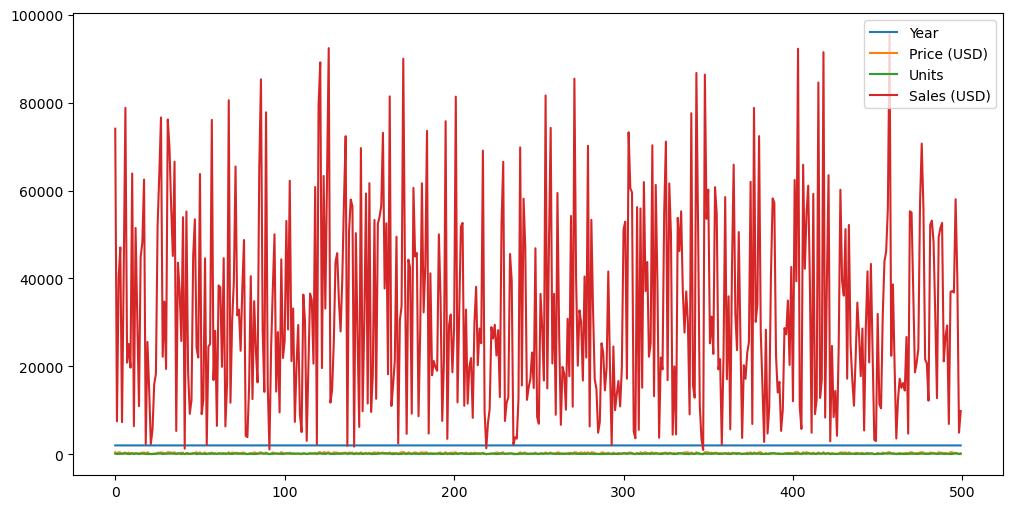

In [4]:
df.plot(figsize = (12,6))

In [5]:
df.index

RangeIndex(start=0, stop=500, step=1)

In [6]:
df.head()

,Year,Country,Product Name,Dosage Form,Manufacturer,Price (USD),Units,Market / Channel,Sales (USD)
0,2025,India,DrugD,Syrup,Novartis,474.74,156,Retail,74059.44
1,2025,India,DrugB,Capsule,Roche,87.22,86,Retail,7500.92
2,2024,Germany,DrugB,IV Infusion,Sanofi,489.55,82,Hospital,40143.10
3,2025,Brazil,DrugC,Tablet,Sanofi,416.42,113,Hospital,47055.46
4,2024,Germany,DrugD,Capsule,Pfizer,43.98,166,Hospital,7300.68


In [7]:
# Step 1: Group data
yearly_sales = df.groupby("Year")["Sales (USD)"].sum()

# Step 2: Plot bar chart
plt.figure(figsize=(10,5))
sales_by_year.plot(kind="bar", color="orange")
plt.title("Global Pharma Sales by Year")
plt.xlabel("Year")
plt.ylabel("Total Sales (USD)")
plt.show()


NameError: name 'sales_by_year' is not defined

<Figure size 1000x500 with 0 Axes>

In [ ]:
plt.figure(figsize=(10,5))
yearly_sales.plot(marker="o", linewidth=2, color="blue")
plt.title("Global Pharma Sales by Year")
plt.xlabel("Year")
plt.ylabel("Total Sales (USD)")
plt.grid(True)
plt.show()

In [ ]:
print("\nSummary Statistics:")
print(df.describe())

In [8]:
# Convert to DataFrame with datetime index
# Convert Year column to datetime index so we can treat it as a proper time series for resampling & forecasting

sales_df = yearly_sales.reset_index()
sales_df["Year"] = pd.to_datetime(sales_df["Year"], format="%Y")
sales_df.set_index("Year", inplace=True)

print("\nYearly Sales:")
print(sales_df)


Yearly Sales:
            Sales (USD)
Year                   
2023-01-01   5344808.47
2024-01-01   5198730.44
2025-01-01   5598575.40


In [9]:
sales_df.index

DatetimeIndex(['2023-01-01', '2024-01-01', '2025-01-01'], dtype='datetime64[ns]', name='Year', freq=None)

In [10]:
 #Resample to monthly data
# Resampling is done to convert yearly data into monthly data.
# Many time series models (ARIMA/SARIMA) work better with higher frequency data (monthly),
# Since we only have yearly totals, we spread them evenly across 12 months as an approximation.


# Spread yearly sales equally across 12 months
monthly_sales = sales_df.resample(rule = "M").ffill()  # M means"Monthly", ffill()-forwardfills thevalue
monthly_sales["Sales (USD)"] = monthly_sales["Sales (USD)"] / 12

sales_series = monthly_sales["Sales (USD)"]




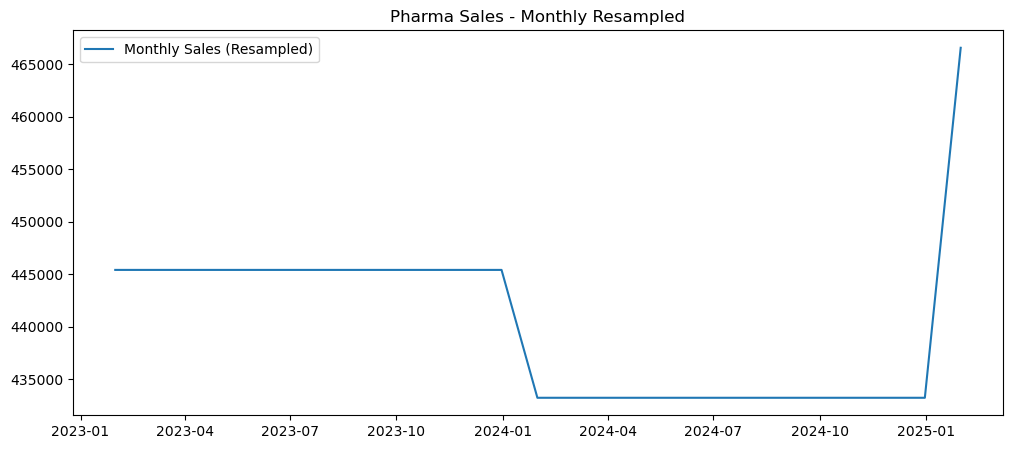

In [11]:
# Plot resampled data
plt.figure(figsize=(12,5))
plt.plot(sales_series, label="Monthly Sales (Resampled)")
plt.title("Pharma Sales - Monthly Resampled")
plt.legend()
plt.show()

In [12]:
sales_series

Year
2023-01-31    445400.705833
2023-02-28    445400.705833
2023-03-31    445400.705833
2023-04-30    445400.705833
2023-05-31    445400.705833
2023-06-30    445400.705833
2023-07-31    445400.705833
2023-08-31    445400.705833
2023-09-30    445400.705833
2023-10-31    445400.705833
2023-11-30    445400.705833
2023-12-31    445400.705833
2024-01-31    433227.536667
2024-02-29    433227.536667
2024-03-31    433227.536667
2024-04-30    433227.536667
2024-05-31    433227.536667
2024-06-30    433227.536667
2024-07-31    433227.536667
2024-08-31    433227.536667
2024-09-30    433227.536667
2024-10-31    433227.536667
2024-11-30    433227.536667
2024-12-31    433227.536667
2025-01-31    466547.950000
Freq: M, Name: Sales (USD), dtype: float64

In [13]:

#This step checks whether the variation in sales grows with time (multiplicative) or stays stable (additive). 

series = sales_series.dropna()

# Split the series into two halves
half = len(series) // 2
first_half = series[:half]
second_half = series[half:]

# Compute standard deviation for each half
std_first = np.std(first_half)
std_second = np.std(second_half)

print("Standard deviation - first half:", std_first)
print("Standard deviation - second half:", std_second)

""""- If the standard deviation in the second half is more than ~1.5 times the first half,  the series is considered multiplicative (variance grows with time).  
- Otherwise, it is considered additive (variance roughly constant). """

# Decide
if std_second > 1.5 * std_first:
    print("Likely Multiplicative (variance grows with trend)")
else:
    print("Likely Additive (variance roughly constant)")


Standard deviation - first half: 1.7462298274040222e-10
Standard deviation - second half: 8878.869049619812
Likely Multiplicative (variance grows with trend)


In [14]:
# Decompose the monthly sales series into trend, seasonal, and residual components(Classical Decomposition)
# - model='multiplicative': assumes seasonal fluctuations grow/shrink with trend
# - period=12: tells the function our data is monthly with a yearly seasonality cycle

from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(sales_series, model= 'multiplicative', period=12)

#trend
trend = decomposition.trend

#Repeating yearly seasonal pattern
seasonal = decomposition.seasonal

#noise after removing trend and seasonality
residual = decomposition.resid 

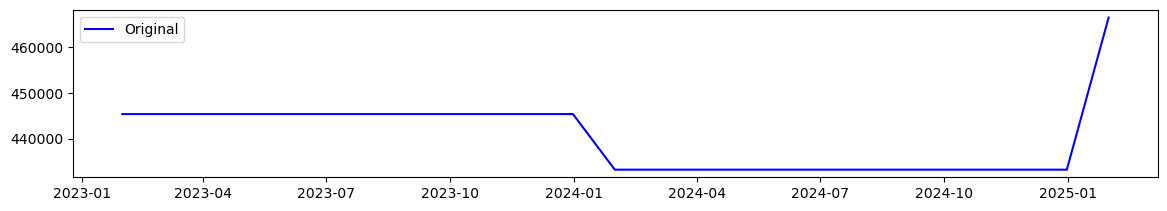

In [15]:
plt.figure(figsize=(14,10))
plt.subplot(411)
plt.plot(sales_series, label="Original", color="blue")
plt.legend(loc="upper left")

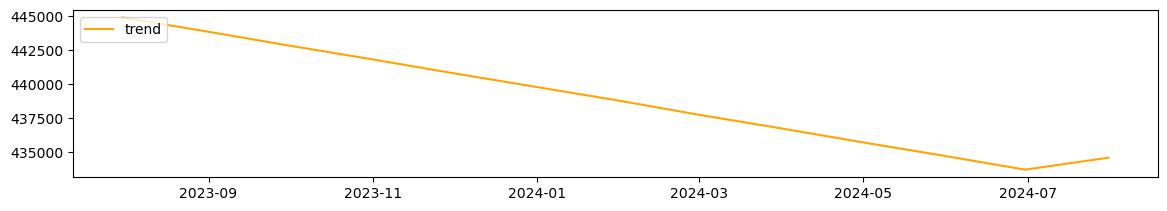

In [16]:
plt.figure(figsize=(14,10))
plt.subplot(411)
plt.plot(trend, label="trend", color='orange')
plt.legend(loc="upper left")

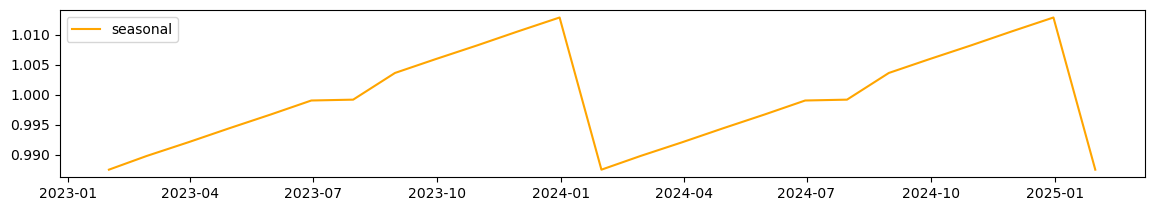

In [17]:
plt.figure(figsize=(14,10))
plt.subplot(411)
plt.plot(seasonal, label="seasonal", color='orange')
plt.legend(loc="upper left")

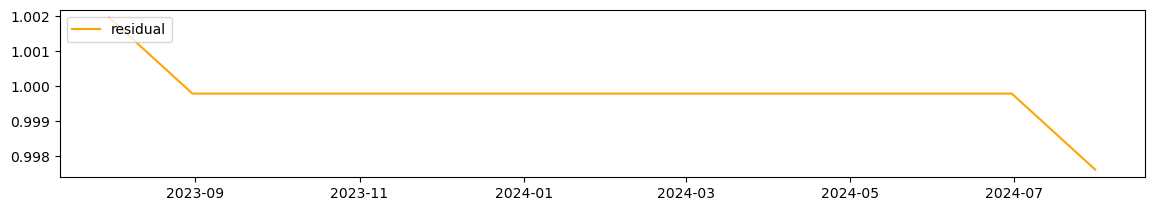

In [18]:
plt.figure(figsize=(14,10))
plt.subplot(411)
plt.plot(residual, label="residual", color='orange')
plt.legend(loc="upper left")

In [19]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss



In [20]:
adf_test = adfuller(sales_series.dropna())   # Run Augmented Dickey-Fuller test on the sales series (drop missing values)
print(f"Test Statistic: {adf_test[0]}") 
print(f"p-value: {adf_test[1]}")

#Decision Rule
if adf_test[1] < 0.05:
    print("Reject Null Hypothesis : series is stationary")
else:
    print("failed to reject null hypothesis: Series not stationary ")

Test Statistic: -1.2824326673350976
p-value: 0.6371705793442932
failed to reject null hypothesis: Series not stationary 


In [21]:
kpss_test = kpss(sales_series.dropna())  # Run KPSS test on the sales series (drop missing values)
print(f"Test Statistic: {kpss_test[0]}")
print(f"P-value: {kpss_test[1]}")

#Decision Rule
if kpss_test[1]< 0.05:
    print("Reject Null hypothesis: Series is non stationary")
else:
    print("Fail to reject null hypothesis: Series is stationary")

Test Statistic: 0.37262561478886996
P-value: 0.08895447638410778
Fail to reject null hypothesis: Series is stationary


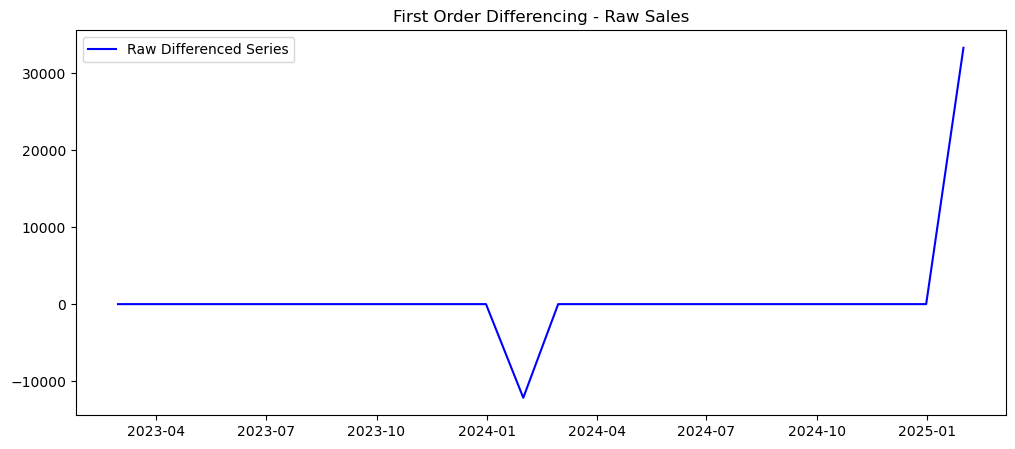

In [22]:
# First differencing (1st order)
sales_diff = sales_series.diff().dropna()

# Plot the differenced series
plt.figure(figsize=(12,5))
plt.plot(sales_diff, label="Raw Differenced Series", color="blue")
plt.title("First Order Differencing - Raw Sales")
plt.legend()
plt.show()




In [23]:
# ADF Test for first difference series
from statsmodels.tsa.stattools import adfuller, kpss

adf_test = adfuller(sales_diff)
print("ADF p-value (raw diff):", adf_test[1])

# KPSS Test
kpss_test = kpss(sales_diff, nlags="auto")
print("KPSS p-value (raw diff):", kpss_test[1])

ADF p-value (raw diff): 0.5687337452210697
KPSS p-value (raw diff): 0.1


C:\Users\SATYAM\AppData\Local\Temp\ipykernel_16436\767053371.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test = kpss(sales_diff, nlags="auto")


After first differencing:

ADF test (p=0.56) → says series is not stationary.

KPSS test (p=0.10) → says series is stationary.

Since the two tests sometimes give opposite answers, we take a practical approach: assume d=1 is enough for differencing and confirm through model fitting.

In [24]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

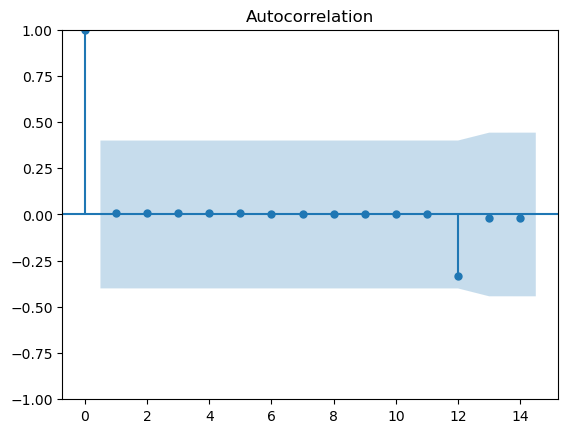

In [25]:
acf = plot_acf(sales_diff.dropna())

The first differencing has removed most of the trend and made the series approximately stationary. The series doesn’t show strong autocorrelations anymore, except possibly at seasonal lag 12.

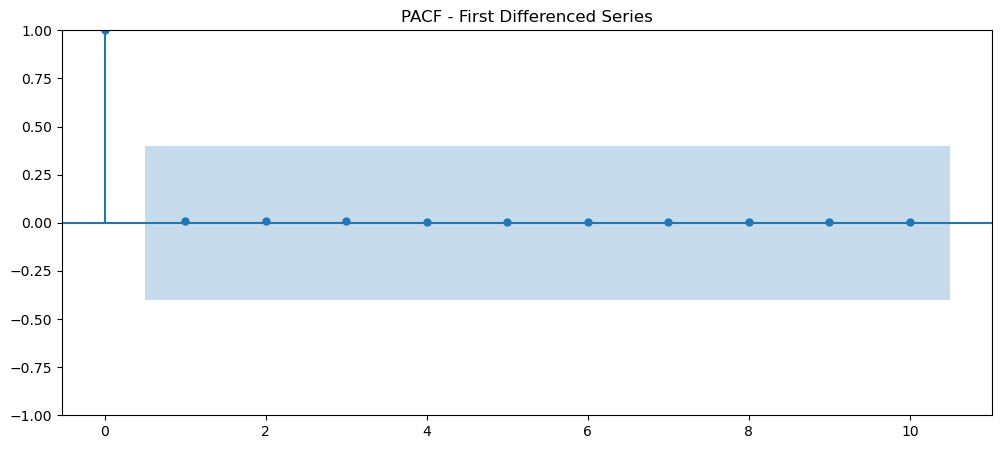

In [26]:
plt.figure(figsize=(12,5))
plot_pacf(sales_diff.dropna(), lags=10, ax=plt.gca(), method="ywm")
plt.title("PACF - First Differenced Series")
plt.show()

 PACF Plot:
 - The large spike at lag 0 is trivial (correlation of the series with itself).
 - All other lags (lag 1 and onwards) are inside the confidence band, i.e. not significant.
 - This means there is no strong autoregressive structure remaining in the differenced series.



In [27]:
sales_series

Year
2023-01-31    445400.705833
2023-02-28    445400.705833
2023-03-31    445400.705833
2023-04-30    445400.705833
2023-05-31    445400.705833
2023-06-30    445400.705833
2023-07-31    445400.705833
2023-08-31    445400.705833
2023-09-30    445400.705833
2023-10-31    445400.705833
2023-11-30    445400.705833
2023-12-31    445400.705833
2024-01-31    433227.536667
2024-02-29    433227.536667
2024-03-31    433227.536667
2024-04-30    433227.536667
2024-05-31    433227.536667
2024-06-30    433227.536667
2024-07-31    433227.536667
2024-08-31    433227.536667
2024-09-30    433227.536667
2024-10-31    433227.536667
2024-11-30    433227.536667
2024-12-31    433227.536667
2025-01-31    466547.950000
Freq: M, Name: Sales (USD), dtype: float64

In [28]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

In [29]:
train = sales_series.loc['2023']
test = sales_series.loc['2024']

In [30]:
horizon = len(test)

In [31]:
print("Train covers:", train.index.min(), "to", train.index.max())
print("Test covers:", train.index.min(), "to", test.index.max())

Train covers: 2023-01-31 00:00:00 to 2023-12-31 00:00:00
Test covers: 2023-01-31 00:00:00 to 2024-12-31 00:00:00


In [32]:
arima_model = ARIMA(sales_series, order=(1,1,1))
arima_res = arima_model.fit()
arima_fc = arima_res.forecast(steps=24)


C:\Users\SATYAM\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order=(1,1,1) → ARIMA with:
 p=1 → includes one AR term (captures short-term persistence)
  d=1 → first differencing (removes trend, makes series stationary)
  q=1 → includes one MA term (captures short-term shocks/noise)

forecast(steps=24) → generate 24 months ahead prediction = 2 years
 (since our data is monthly after resampling)


In [33]:
arima_fc

2025-02-28    466547.95
2025-03-31    466547.95
2025-04-30    466547.95
2025-05-31    466547.95
2025-06-30    466547.95
2025-07-31    466547.95
2025-08-31    466547.95
2025-09-30    466547.95
2025-10-31    466547.95
2025-11-30    466547.95
2025-12-31    466547.95
2026-01-31    466547.95
2026-02-28    466547.95
2026-03-31    466547.95
2026-04-30    466547.95
2026-05-31    466547.95
2026-06-30    466547.95
2026-07-31    466547.95
2026-08-31    466547.95
2026-09-30    466547.95
2026-10-31    466547.95
2026-11-30    466547.95
2026-12-31    466547.95
2027-01-31    466547.95
Freq: M, Name: predicted_mean, dtype: float64

In [34]:
sarima_model = SARIMAX(sales_series, order=(1,1,1), seasonal_order=(1,0,1,12))
sarima_result = sarima_model.fit()
sarima_fore = sarima_result.forecast(steps=24)






C:\Users\SATYAM\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


 SARIMAX with order=(1,1,1), seasonal_order=(1,0,1,12)
 → (p,d,q) = (1,1,1): same as ARIMA → persistence, differencing, noise
 → (P,D,Q,m) = (1,0,1,12): adds yearly seasonality (12 months cycle)

 forecast(steps=24) → forecast 24 months ahead = 2 years


In [37]:
sarima_fore

2025-02-28    466548.619873
2025-03-31    466548.816189
2025-04-30    466548.873673
2025-05-31    466548.890340
2025-06-30    466548.894604
2025-07-31    466548.893737
2025-08-31    466548.886261
2025-09-30    466548.859427
2025-10-31    466548.767486
2025-11-30    466548.453675
2025-12-31    466547.382934
2026-01-31    445142.484932
2026-02-28    445142.453950
2026-03-31    445142.444885
2026-04-30    445142.442281
2026-05-31    445142.441695
2026-06-30    445142.442131
2026-07-31    445142.444331
2026-08-31    445142.452046
2026-09-30    445142.478432
2026-10-31    445142.568476
2026-11-30    445142.875707
2026-12-31    445143.923961
2027-01-31    466099.253130
Freq: M, Name: predicted_mean, dtype: float64

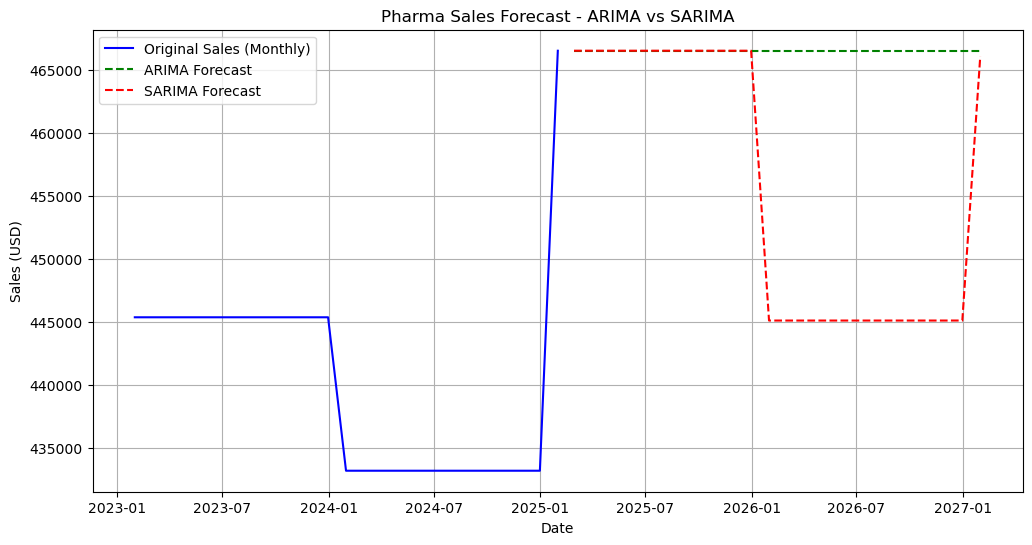

In [38]:
plt.figure(figsize=(12,6))
plt.plot(sales_series, label="Original Sales (Monthly)", color="blue")
plt.plot(arima_fc, label="ARIMA Forecast", color="green", linestyle="--")
plt.plot(sarima_fore, label="SARIMA Forecast", color="red", linestyle="--")

plt.title("Pharma Sales Forecast - ARIMA vs SARIMA")
plt.xlabel("Date")
plt.ylabel("Sales (USD)")
plt.legend()
plt.grid(True)
plt.show()

In [40]:
!pip install prophet


  Obtaining dependency information for prophet from https://files.pythonhosted.org/packages/c7/ef/925617d36c08e0bbdf4347a9b38974ce7ab8fdb5d1a5cf0e3f3c65ea43da/prophet-1.1.7-py3-none-win_amd64.whl.metadata
  Obtaining dependency information for cmdstanpy>=1.0.4 from https://files.pythonhosted.org/packages/2a/80/04b3989f055e555737b3b6944f02112e90cfc4f2e53c763771dded22e684/cmdstanpy-1.2.5-py3-none-any.whl.metadata
  Obtaining dependency information for holidays<1,>=0.25 from https://files.pythonhosted.org/packages/15/de/875f1d928c12336b6a700808e1d250e709cb140e19a9e44e9c66781a84e1/holidays-0.81-py3-none-any.whl.metadata
     ---------------------------------------- 0.0/49.1 kB ? eta -:--:--
     ---------------------------------------- 0.0/49.1 kB ? eta -:--:--
     ---------------------------------------- 0.0/49.1 kB ? eta -:--:--
     --------------- ---------------------- 20.5/49.1 kB 640.0 kB/s eta 0:00:01
     --------------- ---------------------- 20.5/49.1 kB 640.0 kB/s eta 0:00:01


16:50:18 - cmdstanpy - INFO - Chain [1] start processing
16:50:34 - cmdstanpy - INFO - Chain [1] done processing


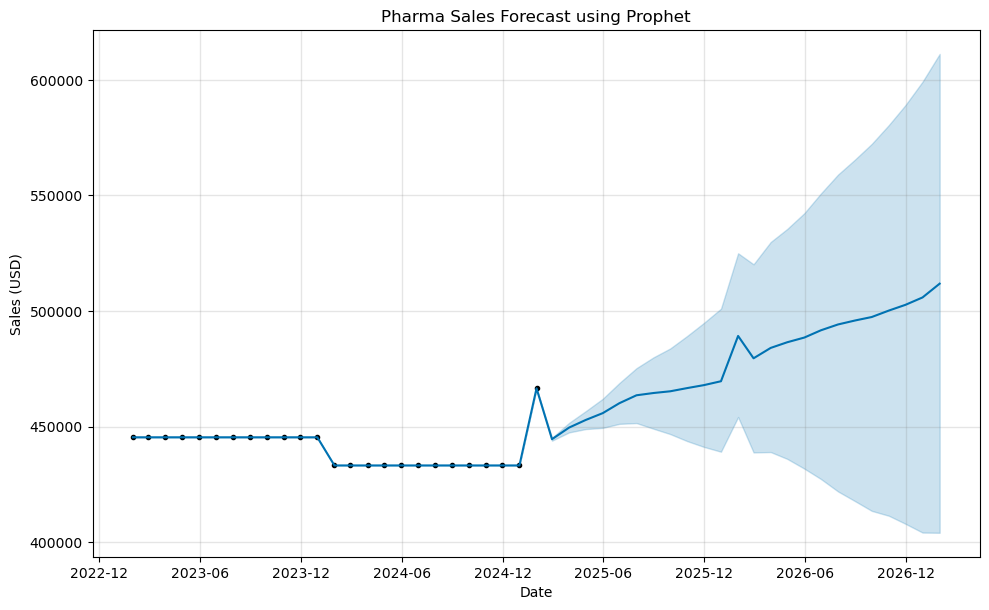

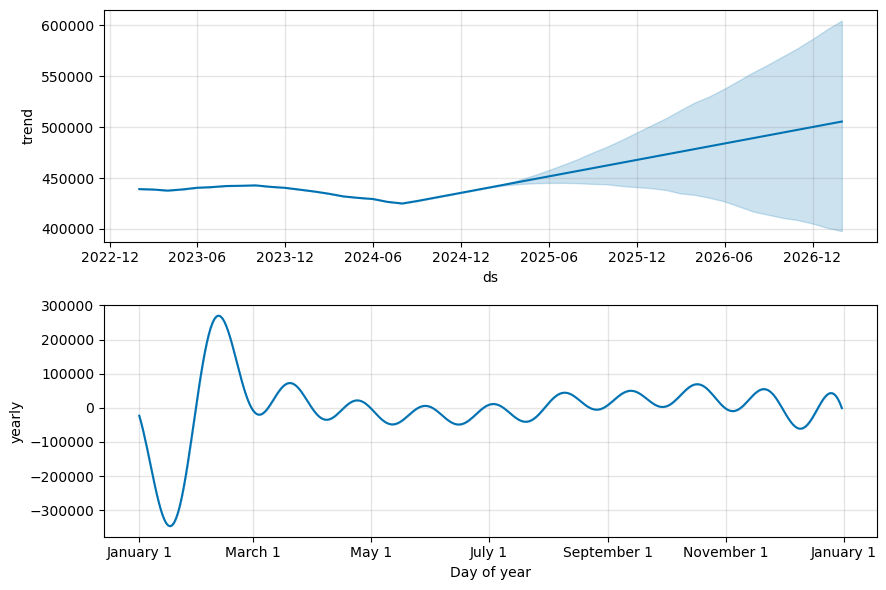

           ds           yhat     yhat_lower     yhat_upper
25 2025-02-28  444583.426641  443927.281569  445185.405026
26 2025-03-31  449601.367584  447512.322145  451651.045900
27 2025-04-30  452885.231936  448947.648116  456681.045514
28 2025-05-31  455853.720254  449481.338740  462065.499992
29 2025-06-30  460138.381078  451208.719861  468863.969828
30 2025-07-31  463563.008923  451549.114853  475285.630591
31 2025-08-31  464551.688153  449087.861244  479985.415175
32 2025-09-30  465284.874150  446795.742025  483797.133706
33 2025-10-31  466684.096424  443731.041595  489245.841433
34 2025-11-30  467952.147885  441252.830922  494841.819762
35 2025-12-31  469634.874865  439164.004310  500995.703497
36 2026-01-31  489215.942489  454161.996510  524961.217567
37 2026-02-28  479557.408807  438854.589484  520202.223390
38 2026-03-31  484041.644328  439013.753048  529827.361296
39 2026-04-30  486492.427649  436057.065698  535483.018001
40 2026-05-31  488527.699679  431838.639731  542320.0352

In [41]:
# Prophet Forecasting Model

from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

# Prepare data for Prophet
prophet_df = sales_series.reset_index()
prophet_df.columns = ["ds", "y"]   # Prophet requires 'ds' and 'y'

# Initialize Prophet model
model = Prophet(yearly_seasonality=True, daily_seasonality=False, weekly_seasonality=False)

# Fit model
model.fit(prophet_df)

# Create future dataframe (forecast for next 24 months = 2 years)
future = model.make_future_dataframe(periods=24, freq='M')

# Forecast
forecast = model.predict(future)

# Plot forecast
fig1 = model.plot(forecast)
plt.title("Pharma Sales Forecast using Prophet")
plt.xlabel("Date")
plt.ylabel("Sales (USD)")
plt.show()

# Plot forecast components (trend + seasonality)
fig2 = model.plot_components(forecast)
plt.show()

# Show forecasted values for future months
forecast_future = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(24)
print(forecast_future)


#Prophet modelling

In [ ]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt


In [45]:
# Convert the sales time series into a DataFrame with columns 'ds' (date) and 'y' (value),
# since Prophet requires this format
prophet_df = sales_series.reset_index()
prophet_df

,Year,Sales (USD)
0,2023-01-31,445400.705833
1,2023-02-28,445400.705833
2,2023-03-31,445400.705833
3,2023-04-30,445400.705833
4,2023-05-31,445400.705833
5,2023-06-30,445400.705833
6,2023-07-31,445400.705833
7,2023-08-31,445400.705833
8,2023-09-30,445400.705833
9,2023-10-31,445400.705833


In [46]:
prophet_df.columns = ["ds", "y"] 

In [47]:
prophet_df

,ds,y
0,2023-01-31,445400.705833
1,2023-02-28,445400.705833
2,2023-03-31,445400.705833
3,2023-04-30,445400.705833
4,2023-05-31,445400.705833
5,2023-06-30,445400.705833
6,2023-07-31,445400.705833
7,2023-08-31,445400.705833
8,2023-09-30,445400.705833
9,2023-10-31,445400.705833


In [48]:
# Initialize the Prophet model
# - yearly_seasonality=True enables yearly seasonality
# - weekly_seasonality=False disables weekly seasonality
# - daily_seasonality=False disables daily seasonality


model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)

In [49]:
# Fit the Prophet model to the sales data
model=model.fit(prophet_df)

16:56:56 - cmdstanpy - INFO - Chain [1] start processing
16:57:12 - cmdstanpy - INFO - Chain [1] done processing


In [50]:
model

In [51]:
#  future dataframe for forecasting
# - periods=24 generates 24 future time points
# - freq="M" specifies monthly frequency
future = model.make_future_dataframe(periods=24, freq="M")

In [52]:
# Generate forecasts for both historical and future dates
forecast = model.predict(future)

In [53]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2023-01-31,439121.928759,445400.880835,445400.880836,439121.928759,439121.928759,6278.952076,6278.952076,6278.952076,6278.952076,6278.952076,6278.952076,0.0,0.0,0.0,445400.880835
1,2023-02-28,438735.010779,445400.665004,445400.665005,438735.010779,438735.010779,6665.654225,6665.654225,6665.654225,6665.654225,6665.654225,6665.654225,0.0,0.0,0.0,445400.665005
2,2023-03-31,437656.635869,445400.682002,445400.682003,437656.635869,437656.635869,7744.046134,7744.046134,7744.046134,7744.046134,7744.046134,7744.046134,0.0,0.0,0.0,445400.682002
3,2023-04-30,438754.674659,445400.808697,445400.808697,438754.674659,438754.674659,6646.134038,6646.134038,6646.134038,6646.134038,6646.134038,6646.134038,0.0,0.0,0.0,445400.808697
4,2023-05-31,440414.663434,445400.872002,445400.872003,440414.663434,440414.663434,4986.208569,4986.208569,4986.208569,4986.208569,4986.208569,4986.208569,0.0,0.0,0.0,445400.872003
5,2023-06-30,441070.255847,445400.845489,445400.845490,441070.255847,441070.255847,4330.589642,4330.589642,4330.589642,4330.589642,4330.589642,4330.589642,0.0,0.0,0.0,445400.845489
6,2023-07-31,442152.473045,445400.831001,445400.831001,442152.473045,442152.473045,3248.357956,3248.357956,3248.357956,3248.357956,3248.357956,3248.357956,0.0,0.0,0.0,445400.831001
7,2023-08-31,442397.374340,445400.762649,445400.762650,442397.374340,442397.374340,3003.388310,3003.388310,3003.388310,3003.388310,3003.388310,3003.388310,0.0,0.0,0.0,445400.762649
8,2023-09-30,442782.285780,445400.701965,445400.701966,442782.285780,442782.285780,2618.416185,2618.416185,2618.416185,2618.416185,2618.416185,2618.416185,0.0,0.0,0.0,445400.701966
9,2023-10-31,441348.501081,445400.824937,445400.824938,441348.501081,441348.501081,4052.323856,4052.323856,4052.323856,4052.323856,4052.323856,4052.323856,0.0,0.0,0.0,445400.824938


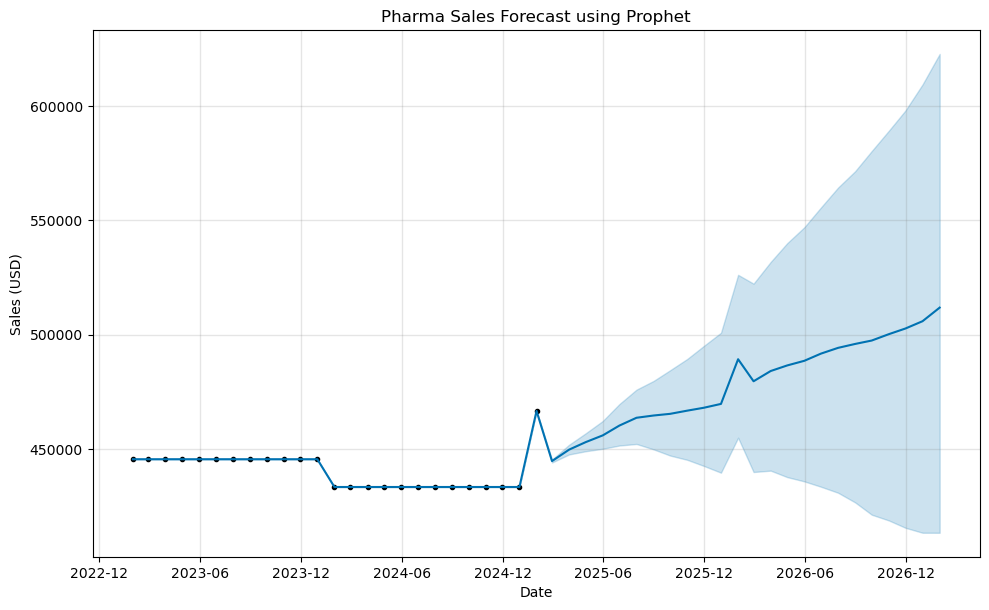

In [54]:
fig = model.plot(forecast)
plt.title("Pharma Sales Forecast using Prophet")
plt.xlabel("Date")
plt.ylabel("Sales (USD)")
plt.show()

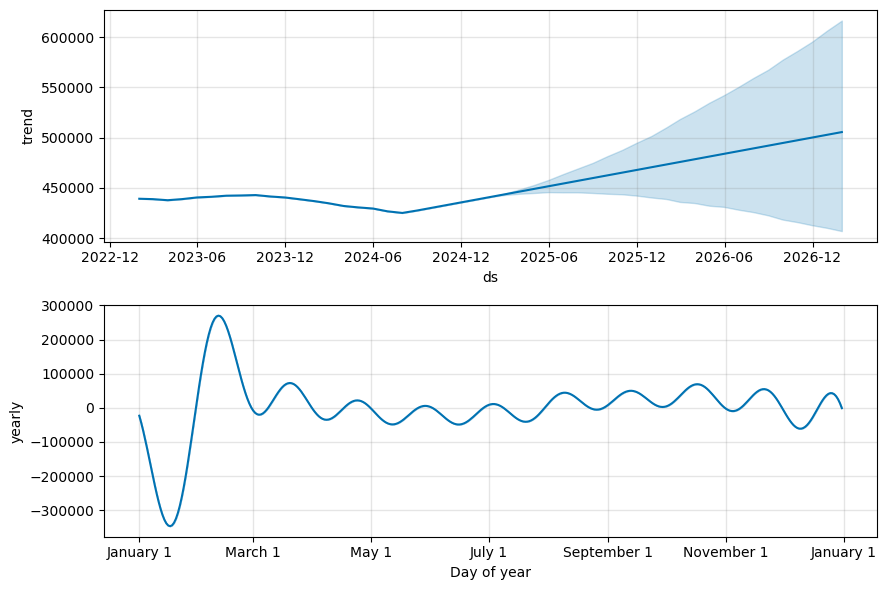

In [55]:
fig1 = model.plot_components(forecast)
plt.show()

In [59]:
# Show forecasted values (last 24 months)
forecast_future = forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail(24)
# Rename columns 
forecast_future = forecast_future.rename(columns={
    "ds": "Date",
    "yhat": "Forecasted_Sales",
    "yhat_lower": "Lower_Bound",
    "yhat_upper": "Upper_Bound"
})
print(forecast_future)

         Date  Forecasted_Sales    Lower_Bound    Upper_Bound
25 2025-02-28     444583.426641  443958.417957  445255.929573
26 2025-03-31     449601.367584  447490.550819  451752.311521
27 2025-04-30     452885.231936  448898.325354  456752.871243
28 2025-05-31     455853.720254  449995.670369  462169.403771
29 2025-06-30     460138.381078  451395.062364  469551.389910
30 2025-07-31     463563.008923  452084.166193  475875.629898
31 2025-08-31     464551.688153  449713.114805  479705.512710
32 2025-09-30     465284.874150  447002.663379  484399.123137
33 2025-10-31     466684.096424  445127.523339  489343.040149
34 2025-11-30     467952.147885  442457.189399  495051.341280
35 2025-12-31     469634.874865  439497.615456  500806.554454
36 2026-01-31     489215.942489  454818.778988  526186.179863
37 2026-02-28     479557.408807  439791.058814  522323.224630
38 2026-03-31     484041.644328  440396.827257  531835.017923
39 2026-04-30     486492.427649  437553.464419  540068.117562
40 2026-

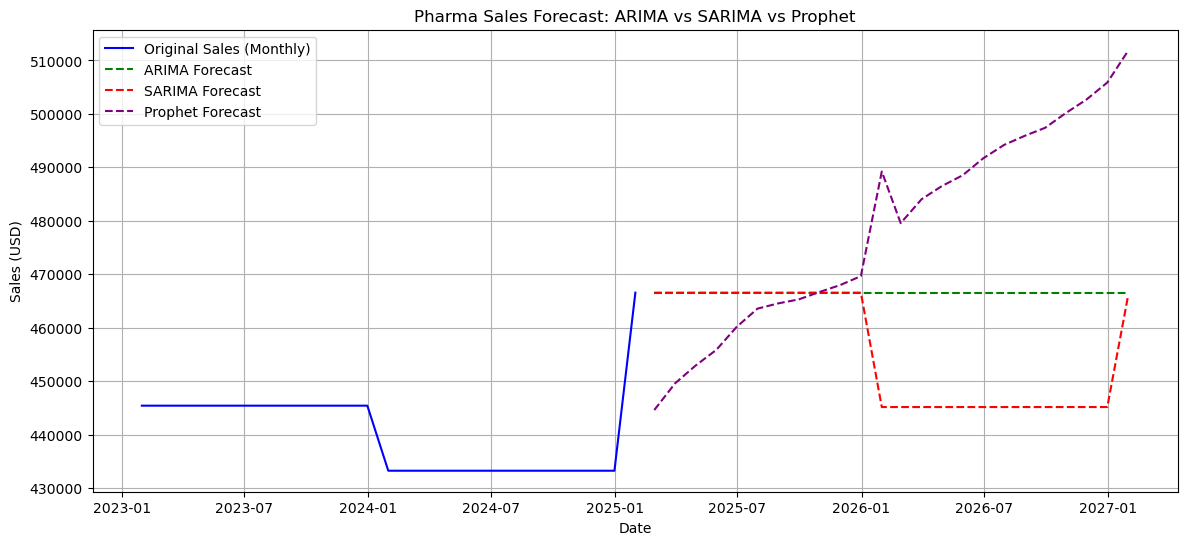

In [58]:
# ===================== Compare ARIMA, SARIMA, Prophet =====================

plt.figure(figsize=(14,6))

# Plot original series
plt.plot(sales_series, label="Original Sales (Monthly)", color="blue")

# Plot ARIMA forecast
plt.plot(arima_fc.index, arima_fc, label="ARIMA Forecast", color="green", linestyle="--")

# Plot SARIMA forecast
plt.plot(sarima_fore.index, sarima_fore, label="SARIMA Forecast", color="red", linestyle="--")

# Plot Prophet forecast (only future, not entire history)
prophet_pred = forecast_future.set_index("ds")["yhat"]
plt.plot(prophet_pred.index, prophet_pred, label="Prophet Forecast", color="purple", linestyle="--")

# Labels, title, legend
plt.title("Pharma Sales Forecast: ARIMA vs SARIMA vs Prophet")
plt.xlabel("Date")
plt.ylabel("Sales (USD)")
plt.legend()
plt.grid(True)
plt.show()
